# Train an FCN for the classification problem

Architecture:
- Input layer: `50` neurons corresponding to the 50 features in train data
- Hidden layers:
    - First with `35` neurons
    - Next with `20` neurons
- Output layer: `3` neurons corresponding to 3 output classes

Loss function: Weighted cross entropy loss due to class imbalance
Optimizer: SGD

In [1]:
from FCN import Net
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Data
df = pd.read_csv('data/cleaned_train.csv')
feats = []
with open('data/features.txt','r') as f:
    feats = [x[:-1] for x in f.readlines()]
df.shape, df.columns, feats

((75018, 53),
 Index(['id', 'marital_status', 'appln_mode', 'appln_order', 'prog_of_study',
        'morn/eve_attend', 'prev_edu', 'prev_edu_grade', 'nationality',
        'mom_edu', 'dad_edu', 'mom_occup', 'admission_grade', 'was_displaced',
        'edu_spl_need', 'has_student_debt', 'no_fee_dues', 'gender',
        'got_scholarship', 'age_at_start', 'sem1_units_credited',
        'sem1_units_enrolled', 'sem1_units_eval', 'sem1_units_approved',
        'sem1_units_grade', 'sem1_units_no_eval', 'sem2_units_credited',
        'sem2_units_enrolled', 'sem2_units_eval', 'sem2_units_approved',
        'sem2_units_grade', 'sem2_units_no_eval', 'unemployment_rate',
        'inflation', 'gdp', 'Target', 'marital_status_log', 'appln_order_log',
        'prog_of_study_log', 'morn/eve_attend_log', 'prev_edu_log',
        'mom_occup_log', 'edu_spl_need_log', 'has_student_debt_log',
        'no_fee_dues_log', 'got_scholarship_log', 'age_at_start_log',
        'sem1_units_credited_log', 'sem1_units

In [3]:
val_counts = dict(df['Target'].value_counts())
val_counts

{'Graduate': 36603, 'Dropout': 23669, 'Enrolled': 14746}

Based on this, we assign `0` as `Graduate`, `1` as `Droupout`, `2` as `Enrolled`.

In [4]:
df['Target_enc'] = df['Target'].apply(lambda x: {'Graduate': 0, 'Dropout': 1, 'Enrolled': 2}[x])
df['Target_enc'].unique()

array([0, 1, 2], dtype=int64)

In [5]:
# Data
X,y = df.drop(columns=['Target','Target_enc','id','nationality']).values, df['Target_enc'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape[1]

50

In [6]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [7]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

In [8]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [9]:
# Instantiate the model, define the optimizer and the loss function
model = Net()
optimizer = optim.AdamW(params=model.parameters(), lr=1e-4)

Class weights

In [10]:
weights = [1.0, val_counts['Dropout']/val_counts['Graduate'], val_counts['Enrolled']/val_counts['Graduate']]
weights

[1.0, 0.6466409857115537, 0.4028631532934459]

In [11]:
# Define class weights
class_weights = torch.tensor(weights, dtype=torch.float32)  # Example weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [12]:
# Training the model
num_epochs = 100
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training loop with tqdm
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    
    # Validation loop with tqdm
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct / len(val_loader.dataset)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

print("Training complete")

Validation Epoch 1/100: 100%|██████████| 469/469 [00:00<00:00, 1783.07it/s]


Epoch 1/100, Train Loss: 0.5555, Validation Loss: 0.3990, Validation Accuracy: 0.7537


Validation Epoch 2/100: 100%|██████████| 469/469 [00:00<00:00, 1739.03it/s]


Epoch 2/100, Train Loss: 0.3707, Validation Loss: 0.3679, Validation Accuracy: 0.7945


Validation Epoch 3/100: 100%|██████████| 469/469 [00:00<00:00, 1680.15it/s]


Epoch 3/100, Train Loss: 0.3517, Validation Loss: 0.3579, Validation Accuracy: 0.8057


Validation Epoch 4/100: 100%|██████████| 469/469 [00:00<00:00, 1787.10it/s]


Epoch 4/100, Train Loss: 0.3439, Validation Loss: 0.3517, Validation Accuracy: 0.8111


Validation Epoch 5/100: 100%|██████████| 469/469 [00:00<00:00, 1747.94it/s]


Epoch 5/100, Train Loss: 0.3387, Validation Loss: 0.3478, Validation Accuracy: 0.8136


Validation Epoch 6/100: 100%|██████████| 469/469 [00:00<00:00, 1737.43it/s]


Epoch 6/100, Train Loss: 0.3352, Validation Loss: 0.3449, Validation Accuracy: 0.8150


Validation Epoch 7/100: 100%|██████████| 469/469 [00:00<00:00, 1790.34it/s]


Epoch 7/100, Train Loss: 0.3327, Validation Loss: 0.3427, Validation Accuracy: 0.8160


Validation Epoch 8/100: 100%|██████████| 469/469 [00:00<00:00, 1773.07it/s]


Epoch 8/100, Train Loss: 0.3305, Validation Loss: 0.3412, Validation Accuracy: 0.8185


Validation Epoch 9/100: 100%|██████████| 469/469 [00:00<00:00, 1626.30it/s]


Epoch 9/100, Train Loss: 0.3290, Validation Loss: 0.3399, Validation Accuracy: 0.8189


Validation Epoch 10/100: 100%|██████████| 469/469 [00:00<00:00, 1706.57it/s]


Epoch 10/100, Train Loss: 0.3276, Validation Loss: 0.3394, Validation Accuracy: 0.8186


Validation Epoch 11/100: 100%|██████████| 469/469 [00:00<00:00, 1684.00it/s]


Epoch 11/100, Train Loss: 0.3263, Validation Loss: 0.3383, Validation Accuracy: 0.8203


Validation Epoch 12/100: 100%|██████████| 469/469 [00:00<00:00, 1733.48it/s]


Epoch 12/100, Train Loss: 0.3255, Validation Loss: 0.3376, Validation Accuracy: 0.8202


Validation Epoch 13/100: 100%|██████████| 469/469 [00:00<00:00, 1771.34it/s]


Epoch 13/100, Train Loss: 0.3245, Validation Loss: 0.3373, Validation Accuracy: 0.8187


Validation Epoch 14/100: 100%|██████████| 469/469 [00:00<00:00, 1701.70it/s]


Epoch 14/100, Train Loss: 0.3236, Validation Loss: 0.3368, Validation Accuracy: 0.8208


Validation Epoch 15/100: 100%|██████████| 469/469 [00:00<00:00, 1827.47it/s]


Epoch 15/100, Train Loss: 0.3230, Validation Loss: 0.3357, Validation Accuracy: 0.8218


Validation Epoch 16/100: 100%|██████████| 469/469 [00:00<00:00, 1756.79it/s]


Epoch 16/100, Train Loss: 0.3223, Validation Loss: 0.3356, Validation Accuracy: 0.8218


Validation Epoch 17/100: 100%|██████████| 469/469 [00:00<00:00, 1777.18it/s]


Epoch 17/100, Train Loss: 0.3217, Validation Loss: 0.3344, Validation Accuracy: 0.8218


Validation Epoch 18/100: 100%|██████████| 469/469 [00:00<00:00, 1728.30it/s]


Epoch 18/100, Train Loss: 0.3211, Validation Loss: 0.3341, Validation Accuracy: 0.8243


Validation Epoch 19/100: 100%|██████████| 469/469 [00:00<00:00, 1701.15it/s]


Epoch 19/100, Train Loss: 0.3207, Validation Loss: 0.3338, Validation Accuracy: 0.8231


Validation Epoch 20/100: 100%|██████████| 469/469 [00:00<00:00, 1731.03it/s]


Epoch 20/100, Train Loss: 0.3201, Validation Loss: 0.3335, Validation Accuracy: 0.8232


Validation Epoch 21/100: 100%|██████████| 469/469 [00:00<00:00, 1774.88it/s]


Epoch 21/100, Train Loss: 0.3197, Validation Loss: 0.3339, Validation Accuracy: 0.8242


Validation Epoch 22/100: 100%|██████████| 469/469 [00:00<00:00, 1774.07it/s]


Epoch 22/100, Train Loss: 0.3192, Validation Loss: 0.3338, Validation Accuracy: 0.8208


Validation Epoch 23/100: 100%|██████████| 469/469 [00:00<00:00, 1818.03it/s]


Epoch 23/100, Train Loss: 0.3185, Validation Loss: 0.3329, Validation Accuracy: 0.8224


Validation Epoch 24/100: 100%|██████████| 469/469 [00:00<00:00, 1740.23it/s]


Epoch 24/100, Train Loss: 0.3182, Validation Loss: 0.3324, Validation Accuracy: 0.8225


Validation Epoch 25/100: 100%|██████████| 469/469 [00:00<00:00, 1750.86it/s]


Epoch 25/100, Train Loss: 0.3178, Validation Loss: 0.3328, Validation Accuracy: 0.8239


Validation Epoch 26/100: 100%|██████████| 469/469 [00:00<00:00, 1700.56it/s]


Epoch 26/100, Train Loss: 0.3174, Validation Loss: 0.3320, Validation Accuracy: 0.8220


Validation Epoch 27/100: 100%|██████████| 469/469 [00:00<00:00, 1796.60it/s]


Epoch 27/100, Train Loss: 0.3172, Validation Loss: 0.3325, Validation Accuracy: 0.8240


Validation Epoch 28/100: 100%|██████████| 469/469 [00:00<00:00, 1248.87it/s]


Epoch 28/100, Train Loss: 0.3168, Validation Loss: 0.3327, Validation Accuracy: 0.8236


Validation Epoch 29/100: 100%|██████████| 469/469 [00:00<00:00, 1717.48it/s]


Epoch 29/100, Train Loss: 0.3165, Validation Loss: 0.3323, Validation Accuracy: 0.8219


Validation Epoch 30/100: 100%|██████████| 469/469 [00:00<00:00, 1740.65it/s]


Epoch 30/100, Train Loss: 0.3162, Validation Loss: 0.3325, Validation Accuracy: 0.8266


Validation Epoch 31/100: 100%|██████████| 469/469 [00:00<00:00, 1748.89it/s]


Epoch 31/100, Train Loss: 0.3158, Validation Loss: 0.3322, Validation Accuracy: 0.8238


Validation Epoch 32/100: 100%|██████████| 469/469 [00:00<00:00, 1732.90it/s]


Epoch 32/100, Train Loss: 0.3157, Validation Loss: 0.3317, Validation Accuracy: 0.8258


Validation Epoch 33/100: 100%|██████████| 469/469 [00:00<00:00, 1690.70it/s]


Epoch 33/100, Train Loss: 0.3153, Validation Loss: 0.3320, Validation Accuracy: 0.8234


Validation Epoch 34/100: 100%|██████████| 469/469 [00:00<00:00, 1797.92it/s]


Epoch 34/100, Train Loss: 0.3150, Validation Loss: 0.3319, Validation Accuracy: 0.8227


Validation Epoch 35/100: 100%|██████████| 469/469 [00:00<00:00, 1802.17it/s]


Epoch 35/100, Train Loss: 0.3147, Validation Loss: 0.3316, Validation Accuracy: 0.8262


Validation Epoch 36/100: 100%|██████████| 469/469 [00:00<00:00, 1764.69it/s]


Epoch 36/100, Train Loss: 0.3146, Validation Loss: 0.3314, Validation Accuracy: 0.8244


Validation Epoch 37/100: 100%|██████████| 469/469 [00:00<00:00, 1780.65it/s]


Epoch 37/100, Train Loss: 0.3145, Validation Loss: 0.3313, Validation Accuracy: 0.8256


Validation Epoch 38/100: 100%|██████████| 469/469 [00:00<00:00, 1693.02it/s]


Epoch 38/100, Train Loss: 0.3139, Validation Loss: 0.3317, Validation Accuracy: 0.8251


Validation Epoch 39/100: 100%|██████████| 469/469 [00:00<00:00, 1749.19it/s]


Epoch 39/100, Train Loss: 0.3140, Validation Loss: 0.3315, Validation Accuracy: 0.8249


Validation Epoch 40/100: 100%|██████████| 469/469 [00:00<00:00, 1764.18it/s]


Epoch 40/100, Train Loss: 0.3137, Validation Loss: 0.3316, Validation Accuracy: 0.8227


Validation Epoch 41/100: 100%|██████████| 469/469 [00:00<00:00, 1622.27it/s]


Epoch 41/100, Train Loss: 0.3135, Validation Loss: 0.3320, Validation Accuracy: 0.8259


Validation Epoch 42/100: 100%|██████████| 469/469 [00:00<00:00, 1754.50it/s]


Epoch 42/100, Train Loss: 0.3133, Validation Loss: 0.3316, Validation Accuracy: 0.8251


Validation Epoch 43/100: 100%|██████████| 469/469 [00:00<00:00, 1749.88it/s]


Epoch 43/100, Train Loss: 0.3131, Validation Loss: 0.3306, Validation Accuracy: 0.8273


Validation Epoch 44/100: 100%|██████████| 469/469 [00:00<00:00, 1741.22it/s]


Epoch 44/100, Train Loss: 0.3132, Validation Loss: 0.3311, Validation Accuracy: 0.8265


Validation Epoch 45/100: 100%|██████████| 469/469 [00:00<00:00, 1733.46it/s]


Epoch 45/100, Train Loss: 0.3126, Validation Loss: 0.3314, Validation Accuracy: 0.8229


Validation Epoch 46/100: 100%|██████████| 469/469 [00:00<00:00, 1728.26it/s]


Epoch 46/100, Train Loss: 0.3127, Validation Loss: 0.3312, Validation Accuracy: 0.8233


Validation Epoch 47/100: 100%|██████████| 469/469 [00:00<00:00, 1582.86it/s]


Epoch 47/100, Train Loss: 0.3123, Validation Loss: 0.3314, Validation Accuracy: 0.8252


Validation Epoch 48/100: 100%|██████████| 469/469 [00:00<00:00, 1532.50it/s]


Epoch 48/100, Train Loss: 0.3123, Validation Loss: 0.3319, Validation Accuracy: 0.8261


Validation Epoch 49/100: 100%|██████████| 469/469 [00:00<00:00, 1657.61it/s]


Epoch 49/100, Train Loss: 0.3121, Validation Loss: 0.3314, Validation Accuracy: 0.8253


Validation Epoch 50/100: 100%|██████████| 469/469 [00:00<00:00, 1874.41it/s]


Epoch 50/100, Train Loss: 0.3119, Validation Loss: 0.3318, Validation Accuracy: 0.8240


Validation Epoch 51/100: 100%|██████████| 469/469 [00:00<00:00, 1807.37it/s]


Epoch 51/100, Train Loss: 0.3116, Validation Loss: 0.3311, Validation Accuracy: 0.8244


Validation Epoch 52/100: 100%|██████████| 469/469 [00:00<00:00, 1801.93it/s]


Epoch 52/100, Train Loss: 0.3114, Validation Loss: 0.3310, Validation Accuracy: 0.8256


Validation Epoch 53/100: 100%|██████████| 469/469 [00:00<00:00, 1792.55it/s]


Epoch 53/100, Train Loss: 0.3114, Validation Loss: 0.3303, Validation Accuracy: 0.8264


Validation Epoch 54/100: 100%|██████████| 469/469 [00:00<00:00, 1773.62it/s]


Epoch 54/100, Train Loss: 0.3115, Validation Loss: 0.3313, Validation Accuracy: 0.8231


Validation Epoch 55/100: 100%|██████████| 469/469 [00:00<00:00, 1708.75it/s]


Epoch 55/100, Train Loss: 0.3116, Validation Loss: 0.3306, Validation Accuracy: 0.8259


Validation Epoch 56/100: 100%|██████████| 469/469 [00:00<00:00, 1773.41it/s]


Epoch 56/100, Train Loss: 0.3110, Validation Loss: 0.3318, Validation Accuracy: 0.8229


Validation Epoch 57/100: 100%|██████████| 469/469 [00:00<00:00, 1899.89it/s]


Epoch 57/100, Train Loss: 0.3111, Validation Loss: 0.3310, Validation Accuracy: 0.8241


Validation Epoch 58/100: 100%|██████████| 469/469 [00:00<00:00, 1514.79it/s]


Epoch 58/100, Train Loss: 0.3109, Validation Loss: 0.3314, Validation Accuracy: 0.8250


Validation Epoch 59/100: 100%|██████████| 469/469 [00:00<00:00, 1847.62it/s]


Epoch 59/100, Train Loss: 0.3106, Validation Loss: 0.3308, Validation Accuracy: 0.8260


Validation Epoch 60/100: 100%|██████████| 469/469 [00:00<00:00, 1825.88it/s]


Epoch 60/100, Train Loss: 0.3106, Validation Loss: 0.3316, Validation Accuracy: 0.8246


Validation Epoch 61/100: 100%|██████████| 469/469 [00:00<00:00, 1666.69it/s]


Epoch 61/100, Train Loss: 0.3106, Validation Loss: 0.3309, Validation Accuracy: 0.8246


Validation Epoch 62/100: 100%|██████████| 469/469 [00:00<00:00, 1855.89it/s]


Epoch 62/100, Train Loss: 0.3106, Validation Loss: 0.3310, Validation Accuracy: 0.8264


Validation Epoch 63/100: 100%|██████████| 469/469 [00:00<00:00, 1859.94it/s]


Epoch 63/100, Train Loss: 0.3100, Validation Loss: 0.3309, Validation Accuracy: 0.8256


Validation Epoch 64/100: 100%|██████████| 469/469 [00:00<00:00, 1799.97it/s]


Epoch 64/100, Train Loss: 0.3098, Validation Loss: 0.3307, Validation Accuracy: 0.8250


Validation Epoch 65/100: 100%|██████████| 469/469 [00:00<00:00, 1904.47it/s]


Epoch 65/100, Train Loss: 0.3099, Validation Loss: 0.3315, Validation Accuracy: 0.8254


Validation Epoch 66/100: 100%|██████████| 469/469 [00:00<00:00, 1358.64it/s]


Epoch 66/100, Train Loss: 0.3099, Validation Loss: 0.3314, Validation Accuracy: 0.8252


Validation Epoch 67/100: 100%|██████████| 469/469 [00:00<00:00, 1877.75it/s]


Epoch 67/100, Train Loss: 0.3098, Validation Loss: 0.3315, Validation Accuracy: 0.8246


Validation Epoch 68/100: 100%|██████████| 469/469 [00:00<00:00, 1795.11it/s]


Epoch 68/100, Train Loss: 0.3100, Validation Loss: 0.3308, Validation Accuracy: 0.8254


Validation Epoch 69/100: 100%|██████████| 469/469 [00:00<00:00, 1478.08it/s]


Epoch 69/100, Train Loss: 0.3099, Validation Loss: 0.3310, Validation Accuracy: 0.8261


Validation Epoch 70/100: 100%|██████████| 469/469 [00:00<00:00, 1788.74it/s]


Epoch 70/100, Train Loss: 0.3093, Validation Loss: 0.3311, Validation Accuracy: 0.8237


Validation Epoch 71/100: 100%|██████████| 469/469 [00:00<00:00, 1759.12it/s]


Epoch 71/100, Train Loss: 0.3093, Validation Loss: 0.3313, Validation Accuracy: 0.8240


Validation Epoch 72/100: 100%|██████████| 469/469 [00:00<00:00, 1814.91it/s]


Epoch 72/100, Train Loss: 0.3094, Validation Loss: 0.3309, Validation Accuracy: 0.8248


Validation Epoch 73/100: 100%|██████████| 469/469 [00:00<00:00, 1828.28it/s]


Epoch 73/100, Train Loss: 0.3093, Validation Loss: 0.3313, Validation Accuracy: 0.8256


Validation Epoch 74/100: 100%|██████████| 469/469 [00:00<00:00, 1207.47it/s]


Epoch 74/100, Train Loss: 0.3089, Validation Loss: 0.3315, Validation Accuracy: 0.8268


Validation Epoch 75/100: 100%|██████████| 469/469 [00:00<00:00, 1859.55it/s]


Epoch 75/100, Train Loss: 0.3093, Validation Loss: 0.3315, Validation Accuracy: 0.8264


Validation Epoch 76/100: 100%|██████████| 469/469 [00:00<00:00, 1720.84it/s]


Epoch 76/100, Train Loss: 0.3089, Validation Loss: 0.3308, Validation Accuracy: 0.8249


Validation Epoch 77/100: 100%|██████████| 469/469 [00:00<00:00, 1844.93it/s]


Epoch 77/100, Train Loss: 0.3088, Validation Loss: 0.3312, Validation Accuracy: 0.8218


Validation Epoch 78/100: 100%|██████████| 469/469 [00:00<00:00, 1802.28it/s]


Epoch 78/100, Train Loss: 0.3088, Validation Loss: 0.3313, Validation Accuracy: 0.8248


Validation Epoch 79/100: 100%|██████████| 469/469 [00:00<00:00, 1811.98it/s]


Epoch 79/100, Train Loss: 0.3087, Validation Loss: 0.3316, Validation Accuracy: 0.8241


Validation Epoch 80/100: 100%|██████████| 469/469 [00:00<00:00, 1742.65it/s]


Epoch 80/100, Train Loss: 0.3085, Validation Loss: 0.3314, Validation Accuracy: 0.8236


Validation Epoch 81/100: 100%|██████████| 469/469 [00:00<00:00, 1859.62it/s]


Epoch 81/100, Train Loss: 0.3086, Validation Loss: 0.3316, Validation Accuracy: 0.8231


Validation Epoch 82/100: 100%|██████████| 469/469 [00:00<00:00, 1356.64it/s]


Epoch 82/100, Train Loss: 0.3087, Validation Loss: 0.3311, Validation Accuracy: 0.8262


Validation Epoch 83/100: 100%|██████████| 469/469 [00:00<00:00, 1814.84it/s]


Epoch 83/100, Train Loss: 0.3087, Validation Loss: 0.3311, Validation Accuracy: 0.8248


Validation Epoch 84/100: 100%|██████████| 469/469 [00:00<00:00, 1759.74it/s]


Epoch 84/100, Train Loss: 0.3081, Validation Loss: 0.3311, Validation Accuracy: 0.8242


Validation Epoch 85/100: 100%|██████████| 469/469 [00:00<00:00, 1898.95it/s]


Epoch 85/100, Train Loss: 0.3081, Validation Loss: 0.3322, Validation Accuracy: 0.8234


Validation Epoch 86/100: 100%|██████████| 469/469 [00:00<00:00, 1779.61it/s]


Epoch 86/100, Train Loss: 0.3084, Validation Loss: 0.3310, Validation Accuracy: 0.8244


Validation Epoch 87/100: 100%|██████████| 469/469 [00:00<00:00, 1724.52it/s]


Epoch 87/100, Train Loss: 0.3079, Validation Loss: 0.3311, Validation Accuracy: 0.8273


Validation Epoch 88/100: 100%|██████████| 469/469 [00:00<00:00, 1871.38it/s]


Epoch 88/100, Train Loss: 0.3081, Validation Loss: 0.3310, Validation Accuracy: 0.8244


Validation Epoch 89/100: 100%|██████████| 469/469 [00:00<00:00, 1928.97it/s]


Epoch 89/100, Train Loss: 0.3078, Validation Loss: 0.3310, Validation Accuracy: 0.8237


Validation Epoch 90/100: 100%|██████████| 469/469 [00:00<00:00, 1304.67it/s]


Epoch 90/100, Train Loss: 0.3081, Validation Loss: 0.3318, Validation Accuracy: 0.8236


Validation Epoch 91/100: 100%|██████████| 469/469 [00:00<00:00, 1796.28it/s]


Epoch 91/100, Train Loss: 0.3080, Validation Loss: 0.3311, Validation Accuracy: 0.8248


Validation Epoch 92/100: 100%|██████████| 469/469 [00:00<00:00, 1818.71it/s]


Epoch 92/100, Train Loss: 0.3079, Validation Loss: 0.3304, Validation Accuracy: 0.8262


Validation Epoch 93/100: 100%|██████████| 469/469 [00:00<00:00, 1845.99it/s]


Epoch 93/100, Train Loss: 0.3075, Validation Loss: 0.3318, Validation Accuracy: 0.8241


Validation Epoch 94/100: 100%|██████████| 469/469 [00:00<00:00, 1936.26it/s]


Epoch 94/100, Train Loss: 0.3080, Validation Loss: 0.3311, Validation Accuracy: 0.8269


Validation Epoch 95/100: 100%|██████████| 469/469 [00:00<00:00, 1850.81it/s]


Epoch 95/100, Train Loss: 0.3075, Validation Loss: 0.3318, Validation Accuracy: 0.8240


Validation Epoch 96/100: 100%|██████████| 469/469 [00:00<00:00, 1741.07it/s]


Epoch 96/100, Train Loss: 0.3076, Validation Loss: 0.3314, Validation Accuracy: 0.8250


Validation Epoch 97/100: 100%|██████████| 469/469 [00:00<00:00, 1815.42it/s]


Epoch 97/100, Train Loss: 0.3077, Validation Loss: 0.3315, Validation Accuracy: 0.8263


Validation Epoch 98/100: 100%|██████████| 469/469 [00:00<00:00, 1809.35it/s]


Epoch 98/100, Train Loss: 0.3073, Validation Loss: 0.3315, Validation Accuracy: 0.8251


Validation Epoch 99/100: 100%|██████████| 469/469 [00:00<00:00, 1759.16it/s]


Epoch 99/100, Train Loss: 0.3074, Validation Loss: 0.3324, Validation Accuracy: 0.8266


Validation Epoch 100/100: 100%|██████████| 469/469 [00:00<00:00, 1280.27it/s]

Epoch 100/100, Train Loss: 0.3072, Validation Loss: 0.3312, Validation Accuracy: 0.8247
Training complete


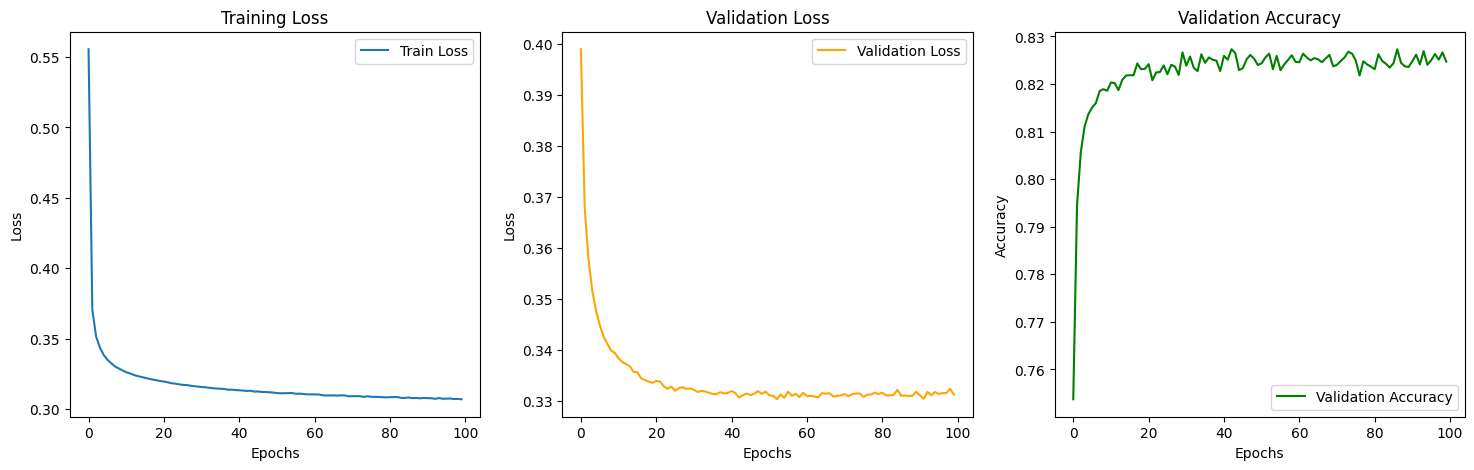

In [13]:
# Plotting the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot train loss
ax1.plot(train_losses, label='Train Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot validation loss
ax2.plot(val_losses, label='Validation Loss', color='orange')
ax2.set_title('Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Plot validation accuracy
ax3.plot(val_accuracies, label='Validation Accuracy', color='green')
ax3.set_title('Validation Accuracy')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')
ax3.legend()

plt.show()